# LOAD LIBRARIES

In [1]:
! pip install zarr fsspec

import xarray as xr
import matplotlib.pyplot as plt
import dask.array as da
import seaborn as sns
import pandas as pd
import numpy as np



---



# PREPROCESS DATA

In [2]:
def era5_data_loader(
    era5_path,
    variables,
    region,
    levels=None,
    average_levels=False,
    daily_resample=True,
    train_range=("1980-01-01", "2015-12-31"),
    val_range=("2016-01-01", "2018-12-31"),
    test_range=("2019-01-01", "2020-12-31")
):

    # ----------------------------------------------------------------------
    # LOAD ERA5
    # ----------------------------------------------------------------------
    print("Loading ERA5 file...")
    ds = xr.open_zarr(
        era5_path,
        chunks={"time": 200},
        consolidated=True,
        storage_options={"token": "anon"}
    )
    print("ERA5 data loaded!\n")

    # ----------------------------------------------------------------------
    # SPATIAL SUBSET
    # ----------------------------------------------------------------------
    print("Calculating spatial subset region...")
    if region['type'] == 'point':
        ds = ds.sel(latitude=region['lat'], longitude=region['lon'], method="nearest")
    elif region['type'] == 'box':
        ds = ds.sel(
            latitude=slice(region["lat_min"], region["lat_max"]),
            longitude=slice(region["lon_min"], region["lon_max"])
        )
    else:
        raise ValueError("region['type'] must be either 'point' or 'box'")
    print("Spatial subset complete.")
    n_lat = len(ds.latitude) if "latitude" in ds.dims else 1
    n_lon = len(ds.longitude) if "longitude" in ds.dims else 1
    print(f"Number of points in the subset region: {n_lat * n_lon}\n")

    # ----------------------------------------------------------------------
    # VARIABLE SUBSET
    # ----------------------------------------------------------------------
    print("Subsetting data to specified variables only...")
    ds = ds[variables]
    print("Variable subset complete.\n")

    # ----------------------------------------------------------------------
    # LEVEL SUBSET
    # ----------------------------------------------------------------------
    if levels is not None:
        print(f"Subsetting to levels: {levels}")
        ds = ds.sel(level=levels)
        print("Level subset complete!\n")

    # ----------------------------------------------------------------------
    # TEMPORAL SUBSET
    # ----------------------------------------------------------------------
    print("Performing temporal subset...")
    full_start, full_end = train_range[0], test_range[1]
    ds = ds.sel(time=slice(full_start, full_end))
    print("Temporal subset complete.\n")

    # ----------------------------------------------------------------------
    # DAILY RESAMPLE
    # ----------------------------------------------------------------------
    if daily_resample:
        print("Calculating daily averages...")

        precip_var = "total_precipitation_6hr"
        non_precip_vars = [v for v in ds.data_vars if v != precip_var]

        if non_precip_vars:
          ds_daily = ds[non_precip_vars].coarsen(time=4, boundary="trim").mean()
        else:
          ds_daily = xr.Dataset()

        if precip_var in ds.data_vars:
          ds_daily[precip_var] = ds[precip_var].coarsen(time=4, boundary="trim").sum()
          ds_daily = ds_daily.rename({precip_var: "total_precipitation"})
          ds_daily["total_precipitation"] = ds_daily["total_precipitation"] * 1000
          ds_daily["total_precipitation"] = ds_daily["total_precipitation"].clip(min=0)
          ds_daily["total_precipitation"].attrs["units"] = "mm"

        ds = ds_daily
        print("Daily resampling complete.\n")

    # ----------------------------------------------------------------------
    # AVERAGE OVER LEVELS
    # ----------------------------------------------------------------------
    if average_levels:
        print("Averaging over vertical levels...")
        level_vars = [v for v in ds.data_vars if "level" in ds[v].dims]
        for v in level_vars:
            ds[v] = ds[v].mean(dim="level")
        if "level" in ds.coords:
            ds = ds.drop_vars("level")
        print("Level averaging complete!\n")

    # ----------------------------------------------------------------------
    # TRAIN VAL TEST SPLIT
    # ----------------------------------------------------------------------
    print("Performing train val test split..")
    ds_train = ds.sel(time=slice(*train_range))
    ds_val   = ds.sel(time=slice(*val_range))
    ds_test  = ds.sel(time=slice(*test_range))
    print("Split complete.")

    print("ERA5 data pre-processing complete.\n")

    return ds_train, ds_val, ds_test

In [3]:
era5 = "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
selected_variables = [
    'specific_humidity',
    'vertical_velocity',
    'temperature',
    'relative_humidity',
    'geopotential',
    'u_component_of_wind',
    'v_component_of_wind',
    'divergence',
    'total_precipitation_6hr'
]
region = {"type": "point", "lat": 30.0, "lon": 270.0}
# region = {"type": "box",
#             "lat_min": 28.5, "lat_max": 33.0,
#             "lon_min": 265, "lon_max": 271}
selected_levels = None
average_levels = True
resamp = True
train_range=("2000-01-01", "2015-12-31")
val_range=("2016-01-01", "2018-12-31")
test_range=("2019-01-01", "2020-12-31")

ds_train, ds_val, ds_test = era5_data_loader(
    era5_path=era5,
    variables=selected_variables,
    region=region,
    levels=selected_levels,
    average_levels=average_levels,
    daily_resample=True,
    train_range=train_range,
    val_range=val_range,
    test_range=test_range
)

Loading ERA5 file...
ERA5 data loaded!

Calculating spatial subset region...
Spatial subset complete.
Number of points in the subset region: 1

Subsetting data to specified variables only...
Variable subset complete.

Performing temporal subset...
Temporal subset complete.

Calculating daily averages...
Daily resampling complete.

Averaging over vertical levels...
Level averaging complete!

Performing train val test split..
Split complete.
ERA5 data pre-processing complete.



In [4]:
print(ds_train)
print(ds_train.dims)

<xarray.Dataset> Size: 257kB
Dimensions:              (time: 5844)
Coordinates:
  * time                 (time) datetime64[ns] 47kB 2000-01-01T09:00:00 ... 2...
    latitude             float64 8B 30.0
    longitude            float64 8B 270.0
Data variables:
    specific_humidity    (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    vertical_velocity    (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    temperature          (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    relative_humidity    (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    geopotential         (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    u_component_of_wind  (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    v_component_of_wind  (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    divergence           (time) float32 23kB dask.array<chunksize=(25,), meta=np.ndarray>
    total_precipitat



---



# EXPLORATORY DATA ANALYSIS

In [5]:
# This takes about 10-15 minutes for date range 2000-2015 at single point
ds_train_l = ds_train.load()
ds_val_l = ds_val.load()
ds_test_l = ds_test.load()

In [22]:
df_train = ds_train_l.to_dataframe()
df_train = df_train.sort_index()
df_train.index = df_train.index.normalize()
print(f"Training Data:")
print(f"Rows: {df_train.shape[0]}")
print(f"Cols: {df_train.shape[1]}\n")

df_val = ds_val_l.to_dataframe()
df_val = df_val.sort_index()
df_val.index   = df_val.index.normalize()
print(f"Validation Data:")
print(f"Rows: {df_val.shape[0]}")
print(f"Cols: {df_val.shape[1]}\n")

df_test = ds_test_l.to_dataframe()
df_test = df_test.sort_index()
df_val.index   = df_val.index.normalize()
print(f"Testing Data:")
print(f"Rows: {df_test.shape[0]}")
print(f"Cols: {df_test.shape[1]}\n")

Training Data:
Rows: 5844
Cols: 11

Validation Data:
Rows: 1096
Cols: 11

Testing Data:
Rows: 731
Cols: 11



In [23]:
vars = [
    'specific_humidity', 'vertical_velocity', 'temperature',
    'relative_humidity', 'geopotential', 'u_component_of_wind',
    'v_component_of_wind', 'divergence', 'total_precipitation'
]

In [24]:
df_train[vars].describe()

,specific_humidity,vertical_velocity,temperature,relative_humidity,geopotential,u_component_of_wind,v_component_of_wind,divergence,total_precipitation
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5.844000e+03,5844.000000
mean,0.002739,-0.002153,249.112976,0.360937,80822.945312,10.794227,0.962438,4.936193e-08,3.701183
std,0.001267,0.070897,2.699541,0.118848,836.215759,10.116124,5.833582,1.609972e-06,8.551167
min,0.000281,-0.737593,240.915924,0.096972,77957.945312,-14.876084,-24.946562,-5.955701e-06,0.000000
25%,0.001658,-0.024615,247.004440,0.267889,80199.794922,2.662693,-2.812788,-9.550963e-07,0.013778
50%,0.002732,0.007029,249.149475,0.355839,80841.285156,10.440818,0.526530,-2.204724e-08,0.496210
75%,0.003812,0.032983,251.629475,0.447748,81551.982422,18.674544,4.369636,9.216929e-07,3.571840
max,0.006607,0.304329,255.708496,0.719251,82569.164062,41.931396,24.258833,1.037731e-05,170.482849


In [25]:
df_train[vars].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5844 entries, 2000-01-01 to 2015-12-31
Freq: D
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   specific_humidity    5844 non-null   float32
 1   vertical_velocity    5844 non-null   float32
 2   temperature          5844 non-null   float32
 3   relative_humidity    5844 non-null   float32
 4   geopotential         5844 non-null   float32
 5   u_component_of_wind  5844 non-null   float32
 6   v_component_of_wind  5844 non-null   float32
 7   divergence           5844 non-null   float32
 8   total_precipitation  5844 non-null   float32
dtypes: float32(9)
memory usage: 251.1 KB


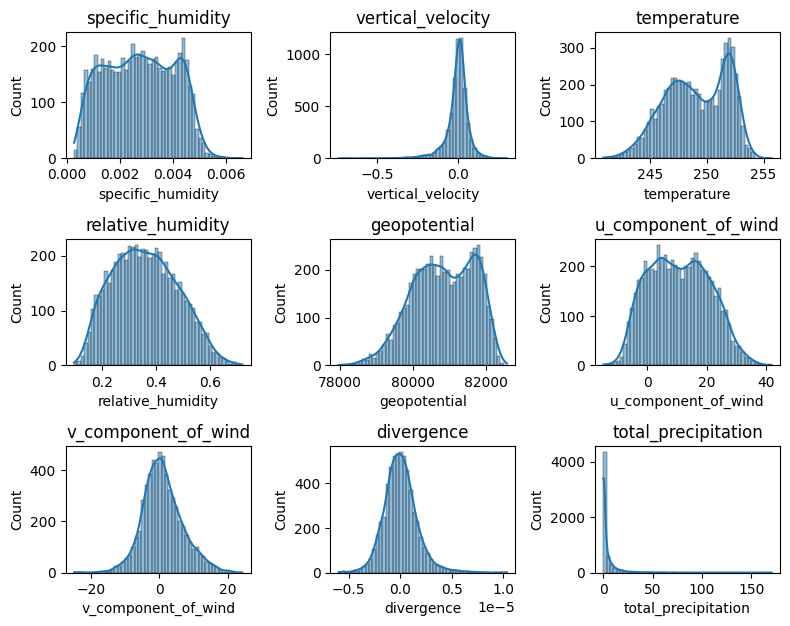

In [26]:
fig, axes = plt.subplots(len(vars)//3 + 1, 3, figsize=(8, 8))
axes = axes.flatten()

for i, var in enumerate(vars):
    sns.histplot(df_train[var], bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f"{var}")

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

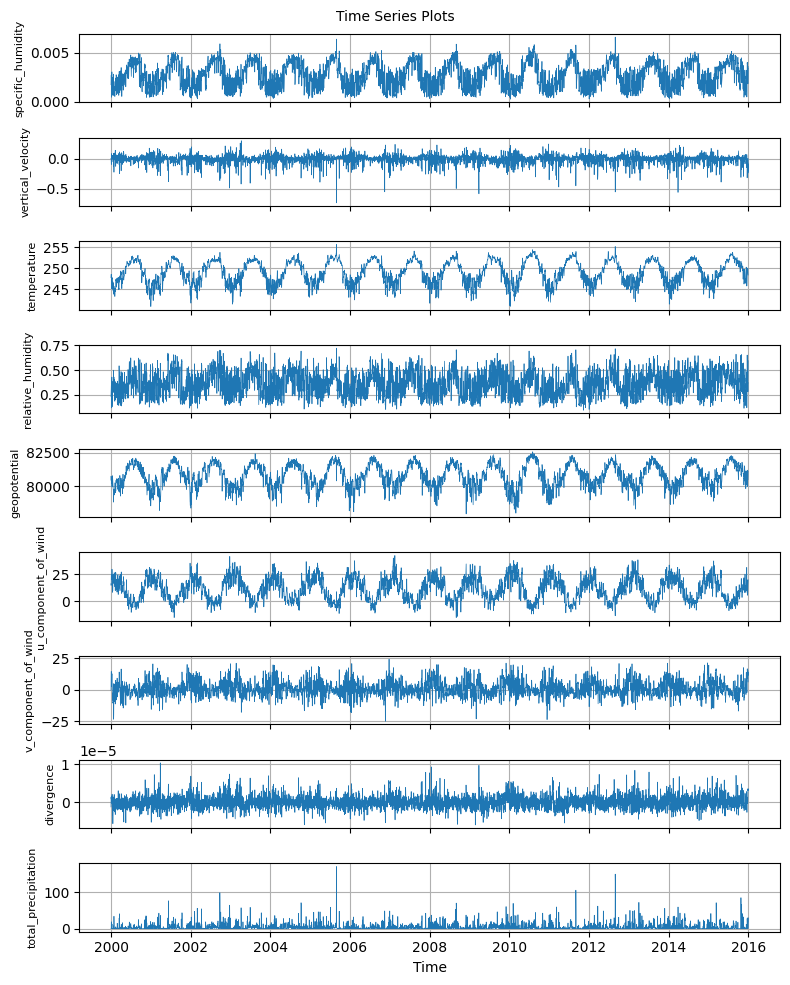

In [28]:
fig, axes = plt.subplots(len(vars), 1, figsize=(8, 10), sharex=True)
for i, var in enumerate(vars):
    axes[i].plot(df_train.index, df_train[var], linewidth=.5)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(True)

axes[-1].set_xlabel("Time")
plt.suptitle("Time Series Plots", fontsize=10)
plt.tight_layout()
plt.show()

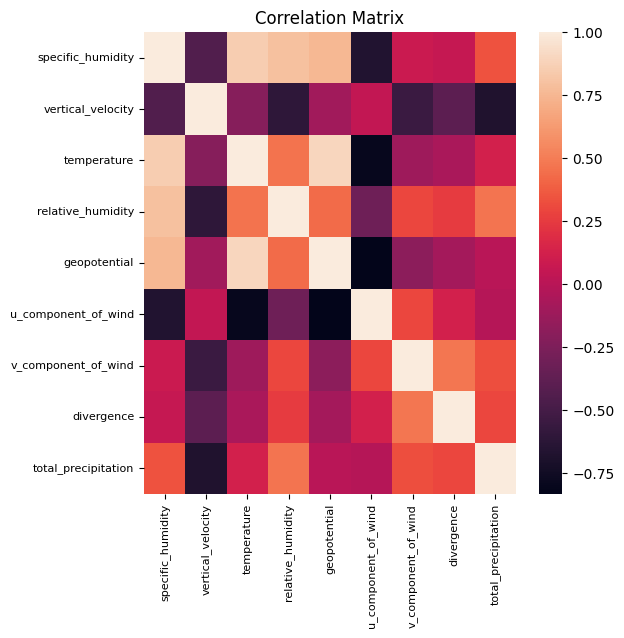

In [29]:
corr = df_train[vars].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr)
plt.title("Correlation Matrix")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

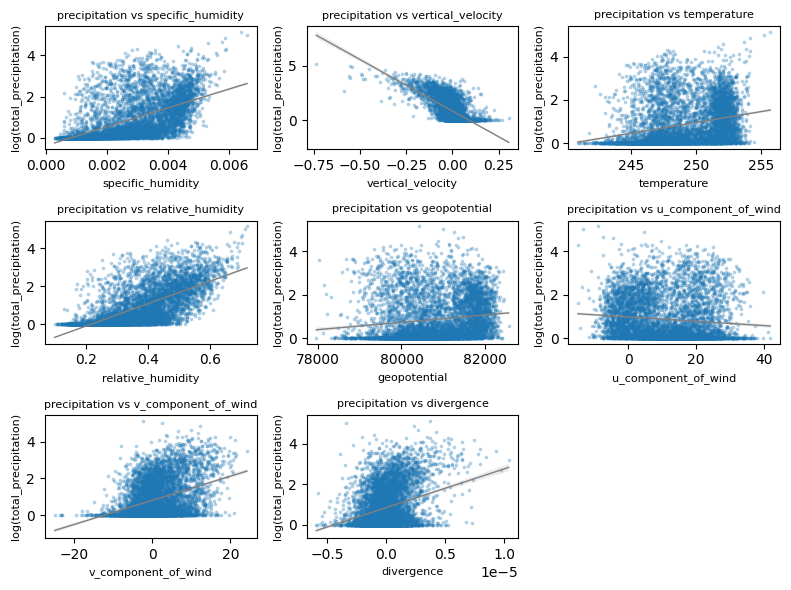

In [30]:
vars_to_plot = [
    v for v in df_train.columns
    if v not in ["time", "total_precipitation", "latitude", "longitude"]
]

num_vars = len(vars_to_plot)
cols = 3
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))
axes = axes.flatten()

log_precip = np.log1p(df_train["total_precipitation"])

for i, var in enumerate(vars_to_plot):
    sns.regplot(
        x=df_train[var],
        y=log_precip,
        ax=axes[i],
        scatter_kws={"alpha": 0.25, "s": 3},
        line_kws={"color": "gray", "linewidth": 1},
        lowess=False,
        order=1
    )

    axes[i].set_title(f"precipitation vs {var}", fontsize=8)
    axes[i].set_xlabel(var, fontsize=8)
    axes[i].set_ylabel("log(total_precipitation)", fontsize=8)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



---



# BASELINE LINEAR REGRESSION

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
# Need to create lagged features t-1, t-2, t-3
df_lr_train = df_train.copy()
df_lr_val = df_val.copy()
df_lr_test = df_test.copy()


lags = [1, 2, 3]
feature_vars = [
    "specific_humidity",
    "vertical_velocity",
    "temperature",
    "relative_humidity",
    "geopotential",
    "u_component_of_wind",
    "v_component_of_wind",
    "divergence"
    ]

feature_vars_recursive = feature_vars + ["total_precipitation"]

for v in feature_vars:
  for l in lags:
    df_lr_train[f"{v}_t-{l}"] = df_lr_train[v].shift(l)
    df_lr_val[f"{v}_t-{l}"] = df_lr_val[v].shift(l)
    df_lr_test[f"{v}_t-{l}"] = df_lr_test[v].shift(l)

for l in lags:
    df_lr_train[f"total_precipitation_t-{l}"] = df_lr_train["total_precipitation"].shift(l)
    df_lr_val[f"total_precipitation_t-{l}"] = df_lr_val["total_precipitation"].shift(l)
    df_lr_test[f"total_precipitation_t-{l}"] = df_lr_test["total_precipitation"].shift(l)

df_lr_train['precip_t+3'] = df_lr_train['total_precipitation'].shift(-3)
df_lr_val['precip_t+3'] = df_lr_val['total_precipitation'].shift(-3)
df_lr_test['precip_t+3'] = df_lr_test['total_precipitation'].shift(-3)

df_lr_train = df_lr_train.dropna()
df_lr_val = df_lr_val.dropna()
df_lr_test = df_lr_test.dropna()

df_lr_train.head()

,specific_humidity,vertical_velocity,temperature,relative_humidity,geopotential,u_component_of_wind,v_component_of_wind,divergence,latitude,longitude,...,v_component_of_wind_t-1,v_component_of_wind_t-2,v_component_of_wind_t-3,divergence_t-1,divergence_t-2,divergence_t-3,total_precipitation_t-1,total_precipitation_t-2,total_precipitation_t-3,precip_t+3
time,,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.002202,-0.093413,247.460022,0.344992,80297.187500,24.780487,14.545997,1.653849e-06,30.0,270.0,...,14.568134,7.214994,-0.564807,8.395400e-07,1.376826e-06,-1.214176e-06,0.533878,0.139728,0.675614,0.000000
2000-01-05,0.000474,0.089302,245.129211,0.119649,80224.093750,23.516136,2.449873,1.105722e-06,30.0,270.0,...,14.545997,14.568134,7.214994,1.653849e-06,8.395400e-07,1.376826e-06,18.611481,0.533878,0.139728,0.006074
2000-01-06,0.000815,0.002784,245.632965,0.192119,80416.109375,21.147064,8.737051,-1.476544e-08,30.0,270.0,...,2.449873,14.545997,14.568134,1.105722e-06,1.653849e-06,8.395400e-07,0.000000,18.611481,0.533878,4.481103
2000-01-07,0.001237,0.045180,246.005692,0.261913,80644.085938,20.715965,6.065154,1.289509e-06,30.0,270.0,...,8.737051,2.449873,14.545997,-1.476544e-08,1.105722e-06,1.653849e-06,0.015302,0.000000,18.611481,12.474529
2000-01-08,0.001687,-0.020993,246.604584,0.350218,80553.304688,19.886534,9.487234,-2.418458e-07,30.0,270.0,...,6.065154,8.737051,2.449873,1.289509e-06,-1.476544e-08,1.105722e-06,0.000000,0.015302,0.000000,0.000000


In [65]:
training_cols = [col for col in df_lr_train.columns if "_t-" in col]
target_col = "precip_t+3"

X_train = df_lr_train[training_cols]
y_train = df_lr_train[target_col]

X_val = df_lr_val[training_cols]
y_val = df_lr_val[target_col]

X_test = df_lr_test[training_cols]
y_test = df_lr_test[target_col]

In [66]:
linreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)

y_pred_train = linreg_pipeline.predict(X_train)
y_pred_val = linreg_pipeline.predict(X_val)
y_pred_test = linreg_pipeline.predict(X_test)

def evaluate_model(y_true, y_pred, label="Data"):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  print(f"{label} RMSE: {rmse:.4f} mm/day")
  print(f"{label} MAE: {mae:.4f} mm/day\n")

print("Single Step Evaluation")
print("----------------------\n")
evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_val, y_pred_val, "Validation")
evaluate_model(y_test, y_pred_test, "Test")

Single Step Evaluation
----------------------

Train RMSE: 8.4991 mm/day
Train MAE: 4.5545 mm/day

Validation RMSE: 8.8170 mm/day
Validation MAE: 4.8497 mm/day

Test RMSE: 7.9245 mm/day
Test MAE: 4.8247 mm/day



*Mean Absolute Error about 4.5-4.8 mm/day (average magnitude of prediction error)*

*Root Mean Square Error about 7.9-8.8 mm/day (includes large errors due to extreme events)*

*Decent results for single-step evaluation. Validation shows a slight increase in error (possible overfitting?) and test performance is similar to validation. Slightly better RMSE which may indicate generalization to unseen data is okay.*

*Overall, single-step evaluation model shows 4-9mm/day error which means it may not correctly predict significant precipitation events.*

In [68]:
def recursive_prediction(df, model, feature_vars, lags, steps=3, target='total_precipitation'):

    df_recursive = df.copy()
    preds_all = []

    for i in range(1, steps+1):
        feature_cols = []
        for v in feature_vars:
            for l in lags:
                col_name = f"{v}_t-{l}"
                if col_name in df_recursive.columns:
                    feature_cols.append(col_name)

        y_next = model.predict(df_recursive[feature_cols])
        preds_all.append(y_next)

        for l in reversed(lags):
            if l == 1:
                df_recursive[f"{target}_t-{l}"] = y_next
            else:
                df_recursive[f"{target}_t-{l}"] = df_recursive[f"{target}_t-{l-1}"]

    df_preds = pd.DataFrame(
        np.array(preds_all).T,
        index=df_recursive.index.normalize(),
        columns=[f"precip_t+{i}" for i in range(1, steps+1)]
    )

    return df_preds

df_test_recursive_preds = recursive_prediction(
    df=df_lr_test,
    model=linreg_pipeline,
    feature_vars=feature_vars_recursive,
    lags=lags,
    steps=3,
    target='total_precipitation'
)

print(df_test_recursive_preds)

            precip_t+1  precip_t+2  precip_t+3
time                                          
2019-01-04    5.018168    4.894124    4.932358
2019-01-05    3.424310    4.150551    4.413904
2019-01-06    2.445642    2.607164    2.091231
2019-01-07    2.867773    2.226568    2.283457
2019-01-08    2.348321    2.265302    2.296339
...                ...         ...         ...
2020-12-24    3.804257    3.685975    3.744087
2020-12-25    2.066751    3.023127    3.373355
2020-12-26    3.529644    3.763832    3.167257
2020-12-27    2.435024    1.718254    1.772684
2020-12-28    3.524560    3.399278    3.445638

[725 rows x 3 columns]


In [71]:
def evaluate_recursive_predictions(df_preds, df_true, label="Data"):
    steps = df_preds.shape[1]
    for i in range(steps):
        step_col = df_preds.columns[i]
        rmse = np.sqrt(mean_squared_error(df_true[step_col], df_preds[step_col]))
        mae = mean_absolute_error(df_true[step_col], df_preds[step_col])
        print(f"{label} Step {i+1} ({step_col}) - RMSE: {rmse:.4f} mm/day, MAE: {mae:.4f} mm/day")

y_test_multi = pd.DataFrame({
    f"precip_t+{i}": df_lr_test["total_precipitation"].shift(-i) for i in range(1, 4)}).dropna()
y_test_multi.index = y_test_multi.index.normalize()

df_test_recursive_preds_aligned = df_test_recursive_preds.loc[y_test_multi.index]

print("Multi Step Evaluation")
print("--------------------\n")
evaluate_recursive_predictions(df_test_recursive_preds_aligned, y_test_multi, label="Test")

Multi Step Evaluation
--------------------

Test Step 1 (precip_t+1) - RMSE: 7.9139 mm/day, MAE: 4.7767 mm/day
Test Step 2 (precip_t+2) - RMSE: 7.9162 mm/day, MAE: 4.7882 mm/day
Test Step 3 (precip_t+3) - RMSE: 7.9319 mm/day, MAE: 4.8321 mm/day


*Errors are fairly stable across the testing steps which means there is not a significant effect from error accumulation. Predictions are similar to single-step predictions and do not seem to vary which may mean they will fail to capture significant precipitation events.*



---



# ERROR ANALYSIS

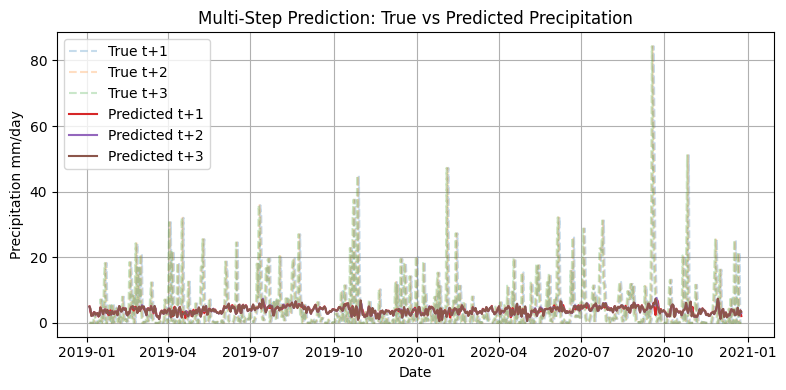

In [79]:
plt.figure(figsize=(8, 4))

for i in range(1, 4):
    plt.plot(
        y_test_multi.index,
        y_test_multi[f'precip_t+{i}'],
        label=f'True t+{i}',
        linestyle='--',
        alpha=0.25
        )

for i in range(1, 4):
    plt.plot(
        df_test_recursive_preds_aligned.index,
        df_test_recursive_preds_aligned[f'precip_t+{i}'],
        label=f'Predicted t+{i}',
    )

plt.title("Multi-Step Prediction: True vs Predicted Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation mm/day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---



# SUMMARY

*Linear regression is able to capture general trends between predictor variables and precipitation amounts, but as seen in the time series plot, precipitation is highly nonlinear and can be intermittent/extreme. As linear regression models trend towards average predictions, extreme rainfall events are failed to be captured by the model.*

*Linear regression smooths predictions which leads to averaged/consistent outputs and extreme precipitation events are rare. Precipitation forecasting contains nonlinear, multiscale atmoshperic patterns that is very complicated to model.*

*To improve overall predictions and better model the nonlinearity of precipitation, a deep learning approach should be explored.*

*Deep learning models to explore:*

*   *LSTM / GRU sequence models*
*   *Temporal Convolutional Networks*
*   *Attention-based architectures (Transformer variations)*



---

